In [1]:
%pylab
%matplotlib inline

import cv2, re, isbi_seg_oak
from segmetrics.study    import *
from segmetrics.regional import *
from segmetrics.boundary import *
from skimage import measure, io

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
result      = cv2.imread('testdata/01_result.png'     , 0)
groundtruth = cv2.imread('testdata/01_groundtruth.png', 0)

## Performance of ISBI SEG Score

In [3]:
%%timeit
study = Study()
study.add_measure(ISBIScore())
study.set_expected(groundtruth)
study.process(result)

1 loop, best of 3: 1.33 s per loop


## Gauging of ISBI SEG Score

In [4]:
n, study = 5, Study()

study.add_measure(Dice()     , 'dice')
study.add_measure(Hausdorff(), 'hausdorff')
study.add_measure(ISBIScore(), 'isbi score')

study.set_expected(groundtruth)
for i in xrange(n): study.process(result)

for measure_name in study.results:
    print('%10s: %6.3f ±%6.3f' % (measure_name, mean(study.results[measure_name]), std(study.results[measure_name])))

 hausdorff: 16.480 ±27.855
isbi score:  0.752 ± 0.237
      dice:  0.916 ± 0.000


In [5]:
def get_official_isbi_seg_score(groundtruth, result, n):
    oak_result = isbi_seg_oak.oak(groundtruth, result, n)
    match = re.compile(r'.*?([\.0-9]+)').match(oak_result)
    if match is not None:
        official_result = float(match.group(1))
        return official_result
    else:
        raise ValueError('Unexpected result:', oak_result)

print('Error:', get_official_isbi_seg_score(groundtruth, result, n) - mean(study.results['isbi score']))

Error: -1.99170556492e-07


Passing `unique=False` to `Study.set_expected` should not affect the result in this case:

In [6]:
study2 = Study()
for measure in study.measures.items():
    study2.add_measure(*measure[::-1])
study2.set_expected(groundtruth, unique=False)
for i in xrange(n): study2.process(result)
for measure_name in study.measures.keys():
    assert allclose(study.results[measure_name], study2.results[measure_name])

## Dealing with Non-unique Labels and ISBI SEG Score

In [7]:
result      = io.imread('testdata/02_result.tif'     , plugin='tifffile')
groundtruth = io.imread('testdata/02_groundtruth.tif', plugin='tifffile')
print(result.min()     , 'to', result.max()     )
print(groundtruth.min(), 'to', groundtruth.max())

0 to 426
0 to 348


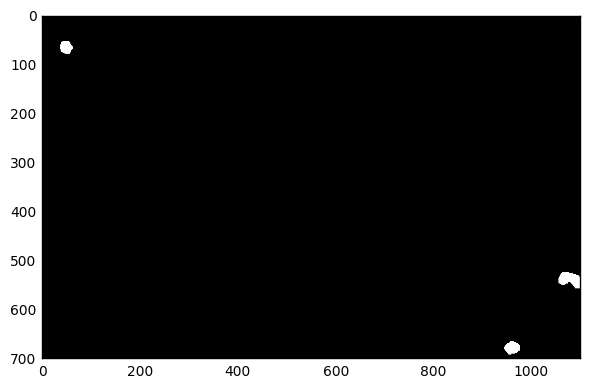

In [8]:
imshow(groundtruth == 1, 'gray')
tight_layout()

In [12]:
official_result = get_official_isbi_seg_score(groundtruth, result, n=1)
print(official_result)

0.805115


Test *without* relabling the ground truth:

In [13]:
study = Study()
study.add_measure(ISBIScore())

study.set_expected(groundtruth)
study.process(result)

our_result = mean(study.results[study.measures.keys()[0]])
print(our_result, our_result - official_result)

0.805115161858 1.61858297432e-07


Test *with* relabling the ground truth:

In [14]:
study = Study()
study.add_measure(ISBIScore())

study.set_expected(groundtruth, unique=False)
study.process(result)

our_result = mean(study.results[study.measures.keys()[0]])
print(our_result, our_result - official_result)

0.814550157719 0.00943515771894


So in order to immitate the official evaluation software, we must not relabel the ground truth.